# Norwegian lightrail

In [1]:
# from norweigian_light_rail import*

In [2]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from genetic_algorithm_pfm import GeneticAlgorithm
from tetra_pfm import TetraSolver
from ipywidgets import Button

from scipy.stats import beta
import numpy as np
from ipywidgets import interact, IntSlider
from scipy.stats import beta
import matplotlib.pyplot as plt
from scipy.stats import norm
from ipywidgets import interact, Dropdown
from scipy.interpolate import pchip_interpolate
 
import warnings
warnings.filterwarnings("ignore")

def objective_municipality(x1, x2):
    """
    Objective for the municipality, describes the development potential as a function of x1 and x2.

    :param x1: capacity (amount of lanes)
    :param x2: number of pontoons
    :param x3:
    :return: development potential
    """
    return 500000 * x1 - 25000 * (-1 * x2 + 10)


def objective_inhabitants(x1, x2):
    """
    Objective for the inhabitants, describes the travel time as a function of x1 and x2.

    :param x1: number of stations
    :param x2: number of trains per hour
    :return: travel time
    """
    return 60 * 1 / x2 + 1.5 * x1


def objective_operator(x1, x2):
    """
    Objective for the light rail operator, describes the maintenance costs as a function of x1 and x2.

    :param x1: number of stations
    :param x2: number of trains per hour
    :return: maintenance costs
    """
    return 120000 * x1 + 0.1 * 120000 * (x2 - 10) / 10


def objective_project_team(x1):
    """
    Objective for the project organisation, describes the project duration as a function of x1.

    :param x1: number of stations
    :return: project duration
    """
    return 0.5 * x1


def objective(variables):
    """
    Objective function that is fed to the GA. Calles the separate preference functions that are declared above.

    :param variables: array with design variable values per member of the population. Can be split by using array
    slicing
    :return: 1D-array with aggregated preference scores for the members of the population.
    """
    x1 = variables[:, 0]  # number of stops
    x2 = variables[:, 1]  # number of trains

    # calculate the preference scores
    p_1 = pchip_interpolate(x_values_1, y_values_1, objective_municipality(x1, x2))
    p_2 = pchip_interpolate(x_values_2, y_values_2, objective_inhabitants(x1, x2))
    p_3 = pchip_interpolate(x_values_3, y_values_3, objective_operator(x1, x2))
    p_4 = pchip_interpolate(x_values_4, y_values_4, objective_project_team(x1))

    # aggregate preference scores and return this to the GA
    return solver.request([slider1.value/100, slider2.value/100, slider3.value/100, slider4.value/100], [p_1, p_2, p_3, p_4])

cons = []
bounds = []
def interactive_plot_solution_space(stations_lower, stations_upper, trains_lower, trains_upper):#boundariesspan, boundariesclearance
    # plot graphical solution
    
    global bounds
    fig, ax = plt.subplots(figsize=(8, 5))

    # Draw constraint lines
#     ax.vlines(clearance_lower, span_lower, span_upper)
#     ax.vlines(clearance_upper, span_lower, span_upper)
#     ax.hlines(span_lower, clearance_lower, clearance_upper)
#     ax.hlines(span_upper, clearance_lower, clearance_upper)

    ax.vlines(stations_lower, -1, 21)
    ax.vlines(stations_upper, -1, 21)
    ax.hlines(trains_lower, -1, 11)
    ax.hlines(trains_upper, -1, 11)


    # Draw the feasible region
    feasible_set = Polygon(np.array([[stations_lower, trains_upper],
                                 [stations_lower, trains_lower],
                                 [stations_upper, trains_lower],
                                 [stations_upper, trains_upper]]),
                       color="lightgrey")
    ax.add_patch(feasible_set)

    ax.set_xlabel('Number of stations')
    ax.set_ylabel('Number of trains per hour')

    
#     ax.legend()
    ax.grid();
    bounds = [[stations_lower, stations_upper], [trains_lower, trains_upper]]
 

class preference_curve:
 
    def __init__(self, lower_bound, mode, upper_bound):
        self.lower_bound = lower_bound
        self.mode = mode
        self.upper_bound = upper_bound
        self.x_values = 0
        self.y_values = 0
 
    def linear(self):
        # Create x values
        x = np.linspace(self.lower_bound, self.upper_bound, 1000)
        self.x_values= x
        # Create y values based on the mode
        y = np.where(x <= self.mode,
                     100 * (x - self.lower_bound) / (self.mode - self.lower_bound),
                     100 * (self.upper_bound - x) / (self.upper_bound - self.mode))
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])
        self.y_values = y
#         self.x_values.append(x)
#         self.y_values.append(y)
 
    def beta_PERT(self):
        x = np.linspace(self.mode - self.lower_bound, self.mode + self.upper_bound, 1000)
        self.x_values = x
        peak = self.mode  # The location of the peak
        min_val = self.mode - self.lower_bound  # The minimum value
        max_val = self.mode + self.upper_bound  # The maximum value
 
        # Calculate the shape parameters for the Beta distribution
        alpha = 1 + 4 * (peak - min_val) / (max_val - min_val)
        beta_b = 1 + 4 * (max_val - peak) / (max_val - min_val)
 
        # Generate the Beta distribution
        y = beta.pdf((x - min_val) / (max_val - min_val), alpha, beta_b)
        self.y_values = (y * (100 / np.max(y))).astype(int)
 
    def parabolic(self):
        # Create x values
        x = np.linspace(self.lower_bound, self.upper_bound, 1000)
        self.x_values = x
 
        # Create y values based on the mode
        if self.lower_bound == self.mode:  # rightward facing parabola
            self.y_values = -100 * ((x - self.mode) ** 2) / (self.upper_bound - self.mode) ** 2 + 100
            self.y_values[x < self.mode] = 0
        elif self.upper_bound == self.mode:  # leftward facing parabola
            self.y_values = -100 * ((x - self.mode) ** 2) / (self.mode - self.lower_bound) ** 2 + 100
            self.y_values[x > self.mode] = 0
        else:  # full parabola
            # Create y values based on the mode
            self.y_values = -100 * ((x - self.mode) ** 2) / (self.mode - self.lower_bound) ** 2 + 100
 
    def normal_distribution(self):
        # Create x values
        x = np.linspace(self.lower_bound, self.upper_bound, 1000)
        self.x_values = x
        # Create y values based on the mode
        std_dev = (self.upper_bound - self.mode) / 3  # Assuming 99.7% of data within [lower_bound, upper_bound]
        y = norm.pdf(x, self.mode, std_dev)
        self.y_values = y / np.max(y) * 100  # Normalize to [0, 100]
        
# Function to update the pie chart
def update_pie_chart(slider1, slider2, slider3, slider4):
    # Calculate the total value of the sliders
    total = slider1 + slider2 + slider3 + slider4
    
    # Check if the total exceeds 100%
    if total > 100:
        print("Sliders cannot add up to more than 100%")
    else:
        # Create a pie chart
        labels = ['Municipality', 'Inhabitants', 'Operator', 'Project team']
        sizes = [slider1, slider2, slider3, slider4]
        explode = (0.1, 0.1, 0.1, 0.1)  # Explode the slices for emphasis
        plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
        plt.show()
        

x_values_1 = []
y_values_1 = []

def interactive_plot_preference1(curve_type, lower_bound, mode, upper_bound):
    global x_values_1
    global y_values_1
    curve = preference_curve(lower_bound, mode, upper_bound)
    if curve_type == 'linear':
        curve.linear()
    elif curve_type == 'beta_PERT':
        curve.beta_PERT()
        
    elif curve_type == 'parabolic':
        curve.parabolic()
        
    elif curve_type == 'normal_distribution':
        curve.normal_distribution()
        
    x_values_1 = curve.x_values
    y_values_1 = curve.y_values   
    
    plt.figure(figsize=(8, 4))
    plt.plot(curve.x_values, curve.y_values)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Interactive Preference Curve')
    plt.grid(True)
    plt.show()
    
    
x_values_2 = []
y_values_2 = []

def interactive_plot_preference2(curve_type, lower_bound, mode, upper_bound):
    global x_values_2
    global y_values_2
    curve = preference_curve(lower_bound, mode, upper_bound)
    if curve_type == 'linear':
        curve.linear()
    elif curve_type == 'beta_PERT':
        curve.beta_PERT()
        
    elif curve_type == 'parabolic':
        curve.parabolic()
        
    elif curve_type == 'normal_distribution':
        curve.normal_distribution()
        
    x_values_2 = curve.x_values
    y_values_2 = curve.y_values   
    
    plt.figure(figsize=(8, 4))
    plt.plot(curve.x_values, curve.y_values)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Interactive Preference Curve')
    plt.grid(True)
    plt.show()
    
x_values_3 = []
y_values_3 = []

def interactive_plot_preference3(curve_type, lower_bound, mode, upper_bound):
    global x_values_3
    global y_values_3
    curve = preference_curve(lower_bound, mode, upper_bound)
    if curve_type == 'linear':
        curve.linear()
    elif curve_type == 'beta_PERT':
        curve.beta_PERT()
        
    elif curve_type == 'parabolic':
        curve.parabolic()
        
    elif curve_type == 'normal_distribution':
        curve.normal_distribution()
        
    x_values_3 = curve.x_values
    y_values_3 = curve.y_values   
    
    plt.figure(figsize=(8, 4))
    plt.plot(curve.x_values, curve.y_values)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Interactive Preference Curve')
    plt.grid(True)
    plt.show()
    
x_values_4 = []
y_values_4 = []

def interactive_plot_preference4(curve_type, lower_bound, mode, upper_bound):
    global x_values_4
    global y_values_4
    curve = preference_curve(lower_bound, mode, upper_bound)
    if curve_type == 'linear':
        curve.linear()
    elif curve_type == 'beta_PERT':
        curve.beta_PERT()
        
    elif curve_type == 'parabolic':
        curve.parabolic()
        
    elif curve_type == 'normal_distribution':
        curve.normal_distribution()
        
    x_values_4 = curve.x_values
    y_values_4 = curve.y_values   
    
    plt.figure(figsize=(8, 4))
    plt.plot(curve.x_values, curve.y_values)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Interactive Preference Curve')
    plt.grid(True)
    plt.show()
    
solver = TetraSolver()
# Function to be executed when the button is clicked
def optimization(x):

    # specify the number of runs of the optimization
    n_runs = 1
    
    # make dictionary with parameter settings for the GA
    print('Run Tetra')
    options = {
        'n_bits': 20,
        'n_iter': 400,
        'n_pop': 350,
        'r_cross': 0.8,
        'max_stall': 10,
        'tetra': True,
        'var_type_mixed': ['int', 'real']
    }
    
    save_array = list()  # list to save the results from every run to
    ga = GeneticAlgorithm(objective=objective, constraints=cons, bounds=bounds, options=options)  # initialize GA
    
    # run the GA and print its result
    for i in range(n_runs):
        print(f'Initialize run {i + 1}')
        score, design_variables, plot_array = ga.run(verbose=False)
    
        print(f'Optimal result for x1 = {design_variables[0]} stations and x2 = {round(design_variables[1], 2)} trains')
        save_array.append([design_variables[0], design_variables[1]])
    
        print(f'Finished run {i + 1}')
        
        # create figure that shows the results in the solution space
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_xlim((0, max(bounds[0]) + 2))
    ax.set_ylim((0, max(bounds[1]) + 2))
    ax.set_xlabel('x1 [Number of stations]')
    ax.set_ylabel('x2 [Number of trains per hour]')
    ax.set_title('Solution space')
    
    # Original list
    lis1 = [bounds[0], bounds[0][::-1]]
    lis2 = [max(bounds[1]), max(bounds[1]), min(bounds[1]), min(bounds[1])]
    
    # iterate through the sublist using List comprehension
    flatList1 = [element for innerList in lis1 for element in innerList]
    
    # define corner points of solution space
    x_fill = flatList1
    y_fill = lis2
    
    ax.fill_between(x_fill, y_fill, color='#539ecd', label='Solution space')
    ax.scatter(np.array(save_array)[:, 0], np.array(save_array)[:, 1], label='Optimal solution Tetra')
    # ax.scatter([9], [12], label='As-built', marker='p', color='r')
    
    ax.grid()  # show grid
    fig.legend()  # show legend
    
    
    1# arrays for plotting continuous preference curves
    mun_min, mun_max = objective_municipality(bounds[0][0], bounds[1][0]), objective_municipality(bounds[0][1], bounds[1][1])
    inh_min, inh_max = objective_inhabitants(bounds[0][0], bounds[1][1]), objective_inhabitants(bounds[0][1], bounds[1][0])
    op_min, op_max = objective_operator(bounds[0][0], bounds[1][0]), objective_operator(bounds[0][1], bounds[1][1])
    prj_min, prj_max = objective_project_team(bounds[0][0]), objective_project_team(bounds[0][1])
    c1 = np.linspace(mun_min, mun_max)
    c2 = np.linspace(inh_min, inh_max)
    c3 = np.linspace(op_min, op_max)
    c4 = np.linspace(prj_min, prj_max)
    
    # calculate the preference functions
    p1 = pchip_interpolate(x_values_1, y_values_1, c1)
    p2 = pchip_interpolate(x_values_2, y_values_2, c2)
    p3 = pchip_interpolate(x_values_3, y_values_3, c3)
    p4 = pchip_interpolate(x_values_4, y_values_4, c4)
    
    # make numpy array of results, to allow for array splicing
    variable = np.array(save_array)
    
    # calculate individual preference scores for the results of the GA, to plot them on the preference curves
    # first for the optimization results
    c1_res = objective_municipality(variable[:, 0], variable[:, 1])
    c2_res = objective_inhabitants(variable[:, 0], variable[:, 1])
    c3_res = objective_operator(variable[:, 0], variable[:, 1])
    c4_res = objective_project_team(variable[:, 0])
    
    p1_res = pchip_interpolate(x_values_1, y_values_1, c1_res)
    p2_res = pchip_interpolate(x_values_2, y_values_2, c2_res)
    p3_res = pchip_interpolate(x_values_3, y_values_3, c3_res)
    p4_res = pchip_interpolate(x_values_4, y_values_4, c4_res)
    
    # and secondly, for the as-built solution, so we can compare the two.
    # c1_res_actual = objective_municipality(9, 12)
    # c2_res_actual = objective_inhabitants(9, 12)
    # c3_res_actual = objective_operator(9, 12)
    # c4_res_actual = objective_project_team(9)
    
    # p1_res_actual = pchip_interpolate(x_values_1, y_values_1, c1_res_actual)
    # p2_res_actual = pchip_interpolate(x_values_2, y_values_2, c2_res_actual)
    # p3_res_actual = pchip_interpolate(x_values_3, y_values_3, c3_res_actual)
    # p4_res_actual = pchip_interpolate(x_values_4, y_values_4, c4_res_actual)
    
    # create figure that plots all preference curves and the preference scores of the returned results of the GA
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.plot(c1, p1, zorder=3, label='Preference curve')
    ax1.scatter(c1_res, p1_res, label='Optimal solution Tetra', color='tab:purple', zorder=1)
    # ax1.scatter(c1_res_actual, p1_res_actual, label='As built', marker='p', color='r', zorder=1)
    ax1.set_xlim((0, mun_max))
    ax1.set_ylim((0, 100))
    ax1.set_title('Municipality')
    ax1.set_xlabel('Developer potential [€]')
    ax1.set_ylabel('Preference score')
    ax1.legend()
    ax1.grid()
    
    fig = plt.figure()
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.plot(c2, p2, zorder=3, label='Preference curve')
    ax2.scatter(c2_res, p2_res, label='Optimal solution Tetra', color='tab:purple', zorder=1)
    # ax2.scatter(c2_res_actual, p2_res_actual, label='As built', marker='p', color='tab:red', zorder=1)
    ax2.set_xlim((0, inh_max))
    ax2.set_ylim((0, 100))
    ax2.set_title('Users and inhabitants')
    ax2.set_xlabel('Travel time [min]')
    ax2.set_ylabel('Preference score')
    ax2.legend()
    ax2.grid()
    
    fig = plt.figure()
    ax3 = fig.add_subplot(1, 1, 1)
    ax3.plot(c3, p3, zorder=3, label='Preference curve')
    ax3.scatter(c3_res, p3_res, label='Optimal solution Tetra', color='tab:purple', zorder=1)
    # ax3.scatter(c3_res_actual, p3_res_actual, label='As built', marker='p', color='tab:red', zorder=1)
    ax3.set_xlim((0, op_max))
    ax3.set_ylim((0, 100))
    ax3.set_title('Light rail operator')
    ax3.set_xlabel('Operational costs [€]')
    ax3.set_ylabel('Preference score')
    ax3.legend()
    ax3.grid()
    
    fig = plt.figure()
    ax4 = fig.add_subplot(1, 1, 1)
    ax4.plot(c4, p4, zorder=3, label='Preference curve')
    ax4.scatter(c4_res, p4_res, label='Optimal solution Tetra', color='tab:purple')
    # ax4.scatter(c4_res_actual, p4_res_actual, label='As built', marker='p', color='tab:red')
    ax4.set_xlim((0, prj_max))
    ax4.set_ylim((0, 100))
    ax4.set_title('Project organisation')
    ax4.set_xlabel('Building time [years]')
    ax4.set_ylabel('Preference score')
    ax4.legend()
    ax4.grid()
    
            

# text

In [3]:
interact(interactive_plot_solution_space, stations_lower=(0, 5, 1), stations_upper=(5, 10, 1),
         trains_lower=(0, 10, 1), trains_upper=(10, 20, 1));

interactive(children=(IntSlider(value=2, description='stations_lower', max=5), IntSlider(value=7, description=…

In [4]:
# Create the sliders
slider1 = IntSlider(min=0, max=100, value=20, description='Municipality %')
slider2 = IntSlider(min=0, max=100, value=40, description='Inhabitants %')
slider3 = IntSlider(min=0, max=100, value=30, description='Operator %')
slider4 = IntSlider(min=0, max=100, value=10, description='Project team %')

# Create the interactive plot
interact(update_pie_chart, slider1=slider1, slider2=slider2, slider3=slider3, slider4=slider4);


interactive(children=(IntSlider(value=20, description='Municipality %'), IntSlider(value=40, description='Inha…

# preference stakeholder municipality

In [5]:
x_values_1 = []
y_values_1 = []

def interactive_plot_preference1(curve_type, lower_bound, mode, upper_bound):
    global x_values_1
    global y_values_1
    curve = preference_curve(lower_bound, mode, upper_bound)
    if curve_type == 'linear':
        curve.linear()
    elif curve_type == 'beta_PERT':
        curve.beta_PERT()
        
    elif curve_type == 'parabolic':
        curve.parabolic()
        
    elif curve_type == 'normal_distribution':
        curve.normal_distribution()
        
    x_values_1 = curve.x_values
    y_values_1 = curve.y_values   
    
    plt.figure(figsize=(8, 4))
    plt.plot(curve.x_values, curve.y_values)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Interactive Preference Curve')
    plt.grid(True)
    plt.show()
    
max_obj = objective_municipality(bounds[0][1], bounds[1][1])
curve_type = Dropdown(options=['linear', 'beta_PERT', 'parabolic', 'normal_distribution'])
preference1 = interact(interactive_plot_preference1, curve_type=curve_type, lower_bound=(1, max_obj, 0.1), mode=(1, max_obj, 0.1), upper_bound=(50, max_obj, 0.1));

interactive(children=(Dropdown(description='curve_type', options=('linear', 'beta_PERT', 'parabolic', 'normal_…

# preference stakeholder inhabitants

In [6]:
max_obj = objective_inhabitants(bounds[0][1], bounds[1][0])
curve_type = Dropdown(options=['linear', 'beta_PERT', 'parabolic', 'normal_distribution'])
preference1 = interact(interactive_plot_preference2, curve_type=curve_type, lower_bound=(1, max_obj, 0.1), mode=(1, max_obj, 0.1), upper_bound=(2, max_obj, 0.1));
    

interactive(children=(Dropdown(description='curve_type', options=('linear', 'beta_PERT', 'parabolic', 'normal_…

# preference stakeholder operator

In [7]:

max_obj = objective_operator(bounds[0][1], bounds[1][1])
curve_type = Dropdown(options=['linear', 'beta_PERT', 'parabolic', 'normal_distribution'])
preference1 = interact(interactive_plot_preference3, curve_type=curve_type, lower_bound=(1, max_obj, 0.1), mode=(1, max_obj, 0.1), upper_bound=(2, max_obj, 0.1));
    

interactive(children=(Dropdown(description='curve_type', options=('linear', 'beta_PERT', 'parabolic', 'normal_…

# Preference stakeholder project team

In [8]:

max_obj = objective_project_team(bounds[0][1])
curve_type = Dropdown(options=['linear', 'beta_PERT', 'parabolic', 'normal_distribution'])
preference1 = interact(interactive_plot_preference4, curve_type=curve_type, lower_bound=(1, max_obj, 0.1), mode=(1, max_obj, 0.1), upper_bound=(2, max_obj, 0.1));

interactive(children=(Dropdown(description='curve_type', options=('linear', 'beta_PERT', 'parabolic', 'normal_…

# Optimization

Button(description='initialize optimization', style=ButtonStyle())

Run Tetra
The type of aggregation is set to None
Initialize run 1
The number of generations is terribly close to the number of max stall iterations. This suggests a too fast convergence and wrong results.
Please be careful in using these results and assume they are wrong unless proven otherwise!
Optimal result for x1 = 3 stations and x2 = 9.71 trains
Finished run 1


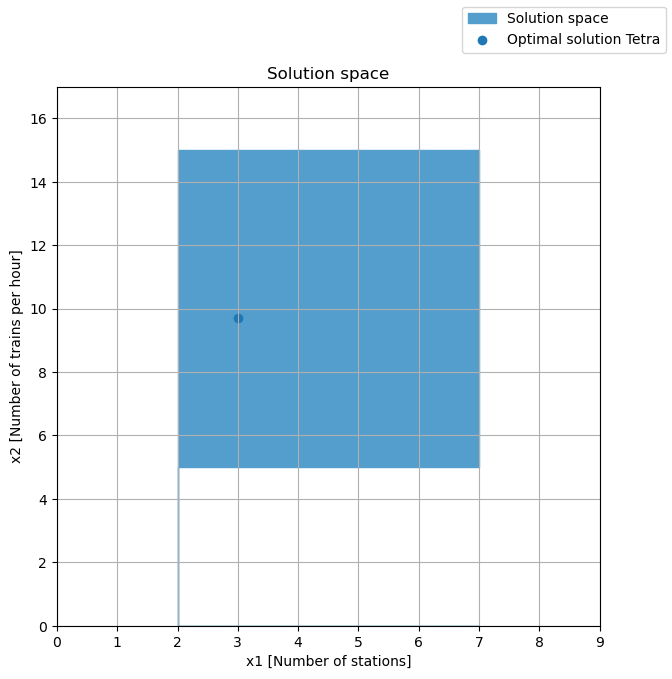

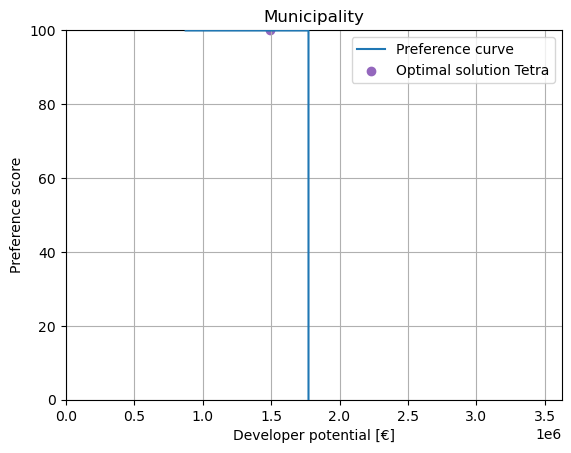

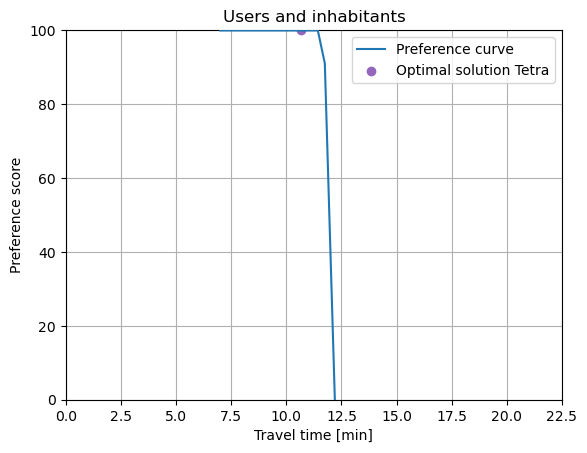

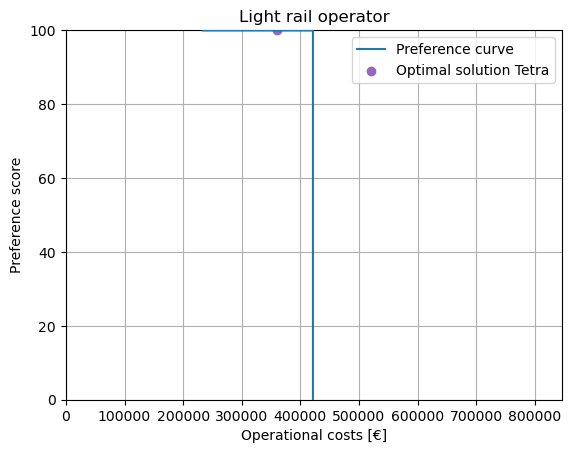

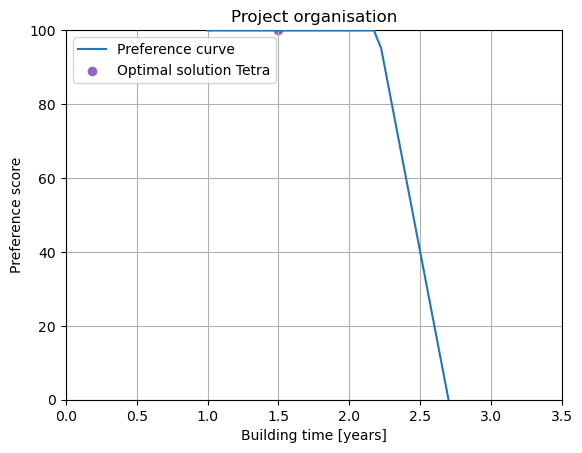

In [9]:
# Create the button widget
button = Button(description='initialize optimization')

# Associate the button with the function to be executed
button.on_click(optimization)

# Display the button
button
